In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [ ]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"

# output files/dir
RESULTS_DIR = "../results/PCAWG"
PLOT_DATA_DIR = "../plot_data/CADD_analysis"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types with driver genes
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
CANCER_TYPES.remove("Pancancer")
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [16]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [17]:
# get all mutations in driver genes
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
	df["cancer_type"] = cancer_type
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	df = df[df["gene"].isin(driver_genes_list)]
	df = pd.merge(df, driver_genes[["gene", "gene_length"]], on="gene", how="left")
	mut_df = pd.concat([mut_df, df])
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/3400457991.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/3400457991.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/3400457991.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/3400457991.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read

(90258, 15)
(82512, 15)


In [18]:
# filter out indels and MNVs without CADD scores
print(mut_df.shape)
mut_df = mut_df[mut_df["CADD_score_raw"].notnull()]
print(mut_df.shape)
mut_df.reset_index(inplace=True)
print(mut_df.shape)

# normalize CADD scores for each gene
mut_df["CADD_score_normalized"] = mut_df.groupby("gene")["CADD_score_raw"].transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)

# get driver status
mut_df["has_driver"] = mut_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
mut_df["has_driver"] = mut_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)

(82512, 15)
(77042, 15)
(77042, 16)


## Distribution of normalized CADD scores

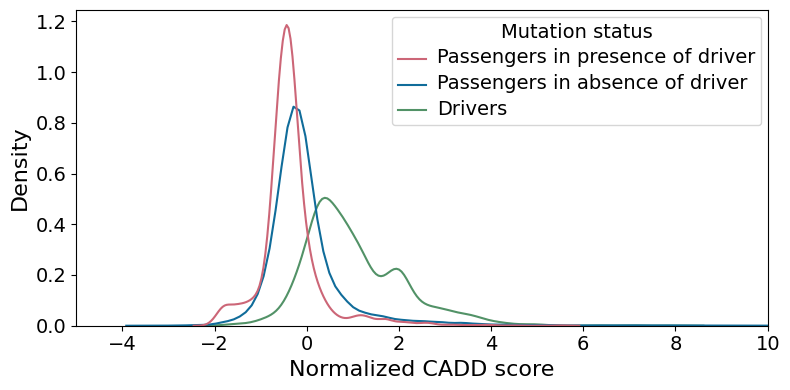

In [ ]:
plt.figure(figsize=(8, 4))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax = sns.kdeplot(
    data=mut_df, 
    x="CADD_score_normalized", 
    hue="has_driver", 
	hue_order=["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"],
    palette=cmap,
	common_norm=False
)
ax.set_xlim(-5, 10)
ax.get_legend().set_title("Mutation status", prop={"size": 14})
# set legend font size
for text in ax.get_legend().get_texts():
	text.set_fontsize(14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Normalized CADD score", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/cadd_score_distribution.png", dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Passengers in presence of driver vs. Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller, P_val:7.208e-146 U_stat=6.340e+07
Passengers in absence of driver vs. Drivers: Mann-Whitney-Wilcoxon test smaller, P_val:0.000e+00 U_stat=2.985e+07


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/2789939491.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(


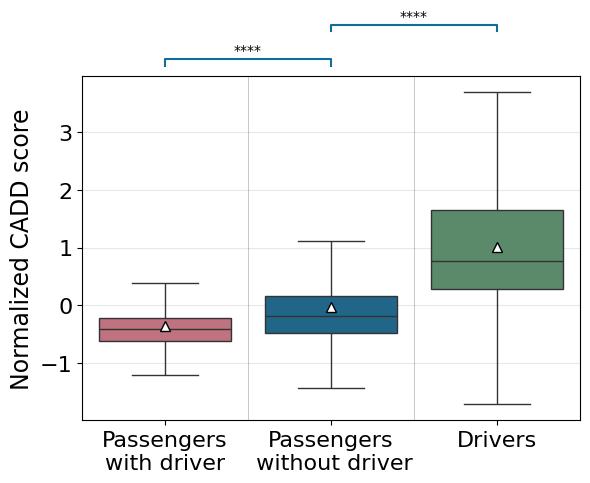

In [ ]:
plt.figure(figsize=(6, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
ax1 = sns.boxplot(
    x="has_driver",
    y="CADD_score_normalized",
    data=mut_df,
    order=order,
    palette=cmap,
    showfliers=False,
    showmeans=True,
	meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"7"}
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(order) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

plt.xlabel("")
plt.xticks(fontsize=16, labels=["Passengers\nwith driver", "Passengers\n without driver", "Drivers"], ticks=[0, 1, 2])
plt.ylabel("Normalized CADD score", fontsize=17)
plt.yticks(fontsize=16)

# get statistical significance annotations
box_pairs = [("Passengers in absence of driver", "Passengers in presence of driver"), 
             ("Passengers in absence of driver", "Drivers")]
annotator = Annotator(
    ax1, 
    x="has_driver", 
    y="CADD_score_normalized",
    order=order,
    data=mut_df, 
    pairs=box_pairs
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', hide_non_significant=True, color=colors[0], loc='outside')
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', hide_non_significant=True, color=colors[1], loc='outside')
annotator.apply_and_annotate()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/cadd_scores_boxplot.png", dpi=300)


# source data
mut_df[["CADD_score_normalized", "has_driver"]].to_csv(f"{PLOT_DATA_DIR}/cadd_scores_boxplot.tsv", sep="\t", index=False)

['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/1410855093.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])


Bone-Leiomyo ['Drivers', 'Passengers in absence of driver']
Breast-LobularCa ['Drivers', 'Passengers in absence of driver']
CNS-Oligo ['Drivers', 'Passengers in absence of driver']
Kidney-ChRCC ['Drivers', 'Passengers in absence of driver']
Lymph-CLL ['Drivers', 'Passengers in absence of driver']
Myeloid-AML ['Drivers', 'Passengers in absence of driver']
Myeloid-MPN ['Drivers', 'Passengers in absence of driver']
[(('Biliary-AdenoCA', 'Passengers in absence of driver'), ('Biliary-AdenoCA', 'Passengers in presence of driver')), (('Bladder-TCC', 'Passengers in absence of driver'), ('Bladder-TCC', 'Passengers in presence of driver'))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
  

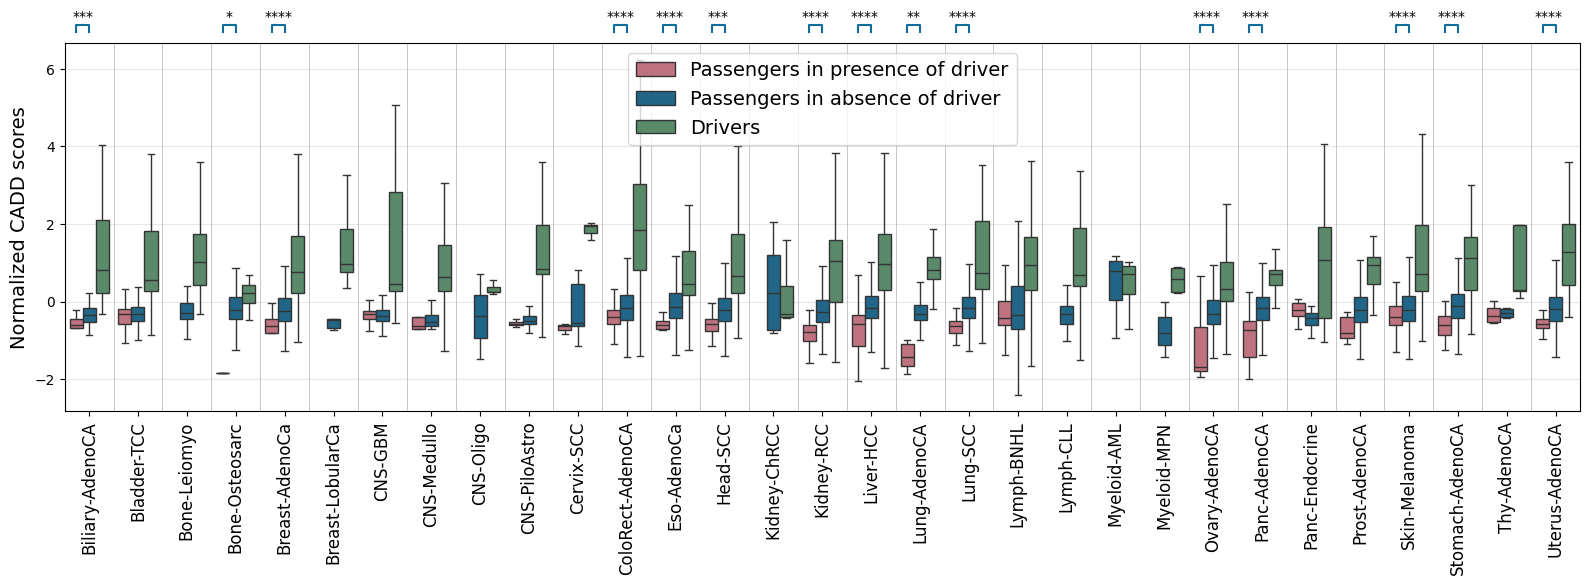

In [21]:
plt.figure(figsize=(16, 6))
mut_df_plot = mut_df.copy()
cancers = mut_df_plot["cancer_type"].unique().tolist()
print(cancers)
cancers.sort()
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="cancer_type",
    y="CADD_score_normalized",
    hue="has_driver",
    data=mut_df_plot,
    order=cancers,
    hue_order=hue_order,
    palette=cmap,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)
      
plt.xlabel("")
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("Normalized CADD scores", fontsize=14)
plt.legend(title="", fontsize=14)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
	cancer_data = mut_df_plot[mut_df_plot["cancer_type"] == cancer]
	if len(cancer_data["has_driver"].unique().tolist()) < 3:
		print(cancer, cancer_data["has_driver"].unique().tolist())
		continue
	box_pairs.append(((cancer, "Passengers in absence of driver"), (cancer, "Passengers in presence of driver")))
print(box_pairs[:2])

annotator = Annotator(
    ax1, 
    box_pairs, 
    data=mut_df_plot, 
    x="cancer_type", 
    y="CADD_score_normalized", 
    hue="has_driver",
    order=cancers, 
    hue_order=hue_order
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/cadd_scores_boxplot_by_cancer_subtype.png", dpi=300)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/1609741141.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=90, fontsize=20)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/1609741141.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])


Myeloid ['Drivers', 'Passengers in absence of driver']
[(('Biliary', 'Passengers in absence of driver'), ('Biliary', 'Passengers in presence of driver')), (('Bladder', 'Passengers in absence of driver'), ('Bladder', 'Passengers in presence of driver'))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_Passengers in presence of driver vs. CNS_Passengers in absence of driver: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:4.801e-04 U_stat=2.646e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Skin_Passengers in presence of driver vs. Skin_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:5.312e-10 U_stat=2.021e

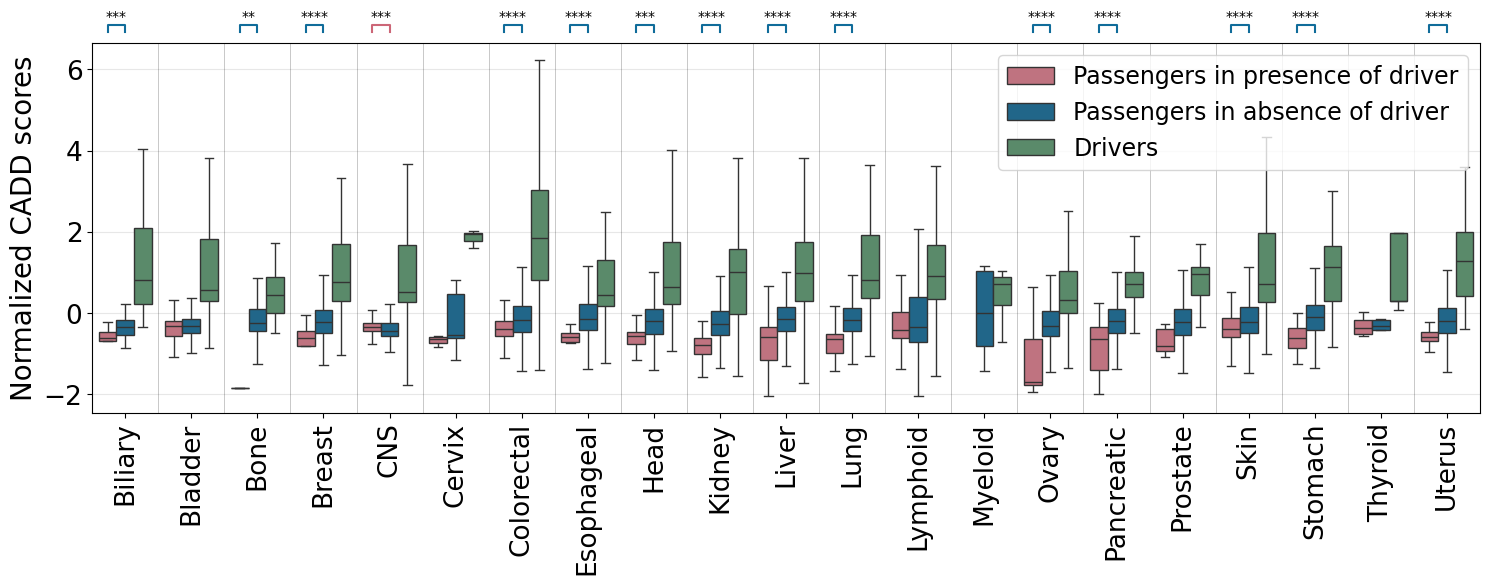

In [22]:
plt.figure(figsize=(15, 6))
# plt.figure(figsize=(18, 6))
mut_df_plot = mut_df.copy()
mut_df_plot["organ"] = mut_df_plot["cancer_type"].apply(lambda x: x.split("-")[0])
cancers = mut_df_plot["organ"].unique().tolist()
cancers.sort()
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="organ",
    y="CADD_score_normalized",
    hue="has_driver",
    data=mut_df_plot,
    order=cancers,
    hue_order=hue_order,
    palette=cmap,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)


# labels with full cancer name
labels = cancers[:]
labels[6] = "Colorectal"
labels[7] = "Esophageal"
labels[12] = "Lymphoid"
labels[15] = "Pancreatic"
labels[16] = "Prostate"
labels[19] = "Thyroid"
ax1.set_xticklabels(labels, rotation=90, fontsize=20)

plt.xlabel("")
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])
plt.xticks(fontsize=19, rotation=90)
plt.ylabel("Normalized CADD scores", fontsize=20)
plt.yticks(fontsize=19)
plt.legend(title="", fontsize=17)
# plt.legend(title="", fontsize=14, loc="upper left", bbox_to_anchor=(1, 1))

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
	cancer_data = mut_df_plot[mut_df_plot["organ"] == cancer]
	if len(cancer_data["has_driver"].unique().tolist()) < 3:
		print(cancer, cancer_data["has_driver"].unique().tolist())
		continue
	box_pairs.append(((cancer, "Passengers in absence of driver"), (cancer, "Passengers in presence of driver")))
print(box_pairs[:2])
annotator = Annotator(
    ax1, 
    box_pairs, 
    data=mut_df_plot, 
    x="organ", 
    y="CADD_score_normalized", 
    hue="has_driver",
    order=cancers, 
    hue_order=hue_order
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/cadd_scores_by_cancer_organ.png", dpi=300)

# source data
mut_df_plot[["organ", "has_driver", "CADD_score_normalized"]].to_csv(f"{PLOT_DATA_DIR}/cadd_scores_by_cancer_organ.tsv", sep="\t", index=False)

## Distribution of cumulative normalized CADD scores

In [23]:
# get sum of normalized CADD scores for each sample
mut_df["CADD_score_min_max_normalized"] = mut_df.groupby("gene")["CADD_score_raw"].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() - x.min() > 0 else 0.5)
mut_sum_df = mut_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver"]).agg({
    "CADD_score_min_max_normalized": "sum",
    "cancer_type": "first"
}).reset_index()
mut_sum_df.rename(columns={"CADD_score_min_max_normalized": "CADD_score_norm_sum"}, inplace=True)
mut_sum_df["CADD_score_norm_sum"] = np.log10(mut_sum_df["CADD_score_norm_sum"] + 1)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Passengers in presence of driver vs. Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller, P_val:4.159e-26 U_stat=1.185e+06


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/2331694207.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/2331694207.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax1 = sns.boxplot(


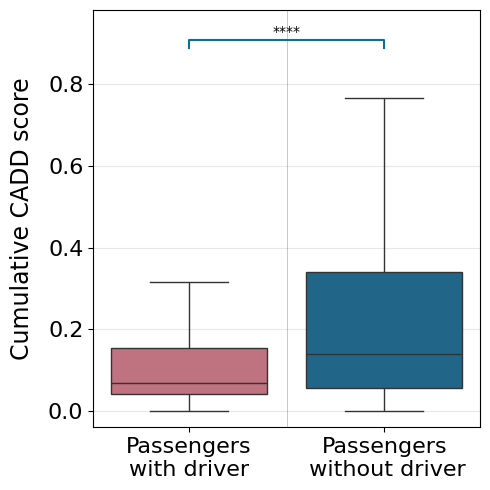

In [24]:
plt.figure(figsize=(5, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
order = ["Passengers in presence of driver", "Passengers in absence of driver"]
ax1 = sns.boxplot(
    x="has_driver",
    y="CADD_score_norm_sum",
    data=mut_sum_df,
    order=order,
    palette=cmap,
    showfliers=False,
	meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"7"}
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(order) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

plt.xlabel("")
plt.xticks(fontsize=16, labels=["Passengers\nwith driver", "Passengers\n without driver", "Drivers"], ticks=[0, 1, 2])
plt.ylabel("Cumulative CADD score", fontsize=17, labelpad=10)
plt.yticks(fontsize=16)

# get statistical significance annotations
box_pairs = [("Passengers in absence of driver", "Passengers in presence of driver")]
annotator = Annotator(
    ax1, 
    x="has_driver", 
    y="CADD_score_norm_sum",
    order=order,
    data=mut_sum_df, 
    pairs=box_pairs
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/cumulative_cadd_scores_boxplot.png", dpi=300)

# source data
mut_sum_df[["has_driver", "CADD_score_norm_sum"]].to_csv(f"{PLOT_DATA_DIR}/cumulative_cadd_scores_boxplot.tsv", sep="\t", index=False)

Myeloid ['Drivers', 'Passengers in absence of driver']
[(('Biliary', 'Passengers in absence of driver'), ('Biliary', 'Passengers in presence of driver')), (('Bladder', 'Passengers in absence of driver'), ('Bladder', 'Passengers in presence of driver'))]


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/3021332322.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax1 = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97158/3021332322.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Kidney_Passengers in presence of driver vs. Kidney_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:1.152e-04 U_stat=1.514e+03
Liver_Passengers in presence of driver vs. Liver_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:1.768e-06 U_stat=1.305e+04
Lung_Passengers in presence of driver vs. Lung_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:3.392e-08 U_stat=2.314e+03
Ovary_Passengers in presence of driver vs. Ovary_Passenger

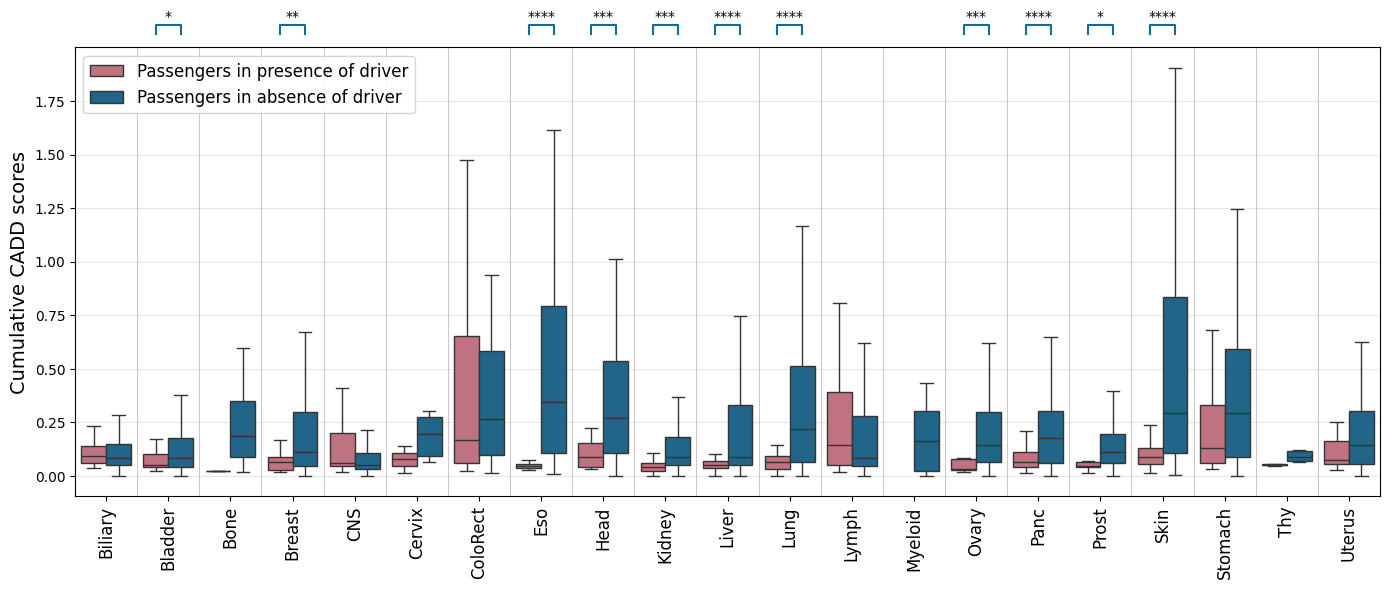

In [25]:
plt.figure(figsize=(14, 6))
mut_df_plot = mut_sum_df.copy()
mut_df_plot["organ"] = mut_df_plot["cancer_type"].apply(lambda x: x.split("-")[0])
cancers = mut_df_plot["organ"].unique().tolist()
cancers.sort()
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver"]
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="organ",
    y="CADD_score_norm_sum",
    hue="has_driver",
    data=mut_df_plot,
    order=cancers,
    hue_order=hue_order,
    palette=cmap,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)
      
plt.xlabel("")
xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels([x.get_text().replace("_", "/") for x in xticklabels])
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("Cumulative CADD scores", fontsize=14)
plt.legend(title="", fontsize=12)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
	cancer_data = mut_df_plot[mut_df_plot["organ"] == cancer]
	if len(cancer_data["has_driver"].unique().tolist()) < 3:
		print(cancer, cancer_data["has_driver"].unique().tolist())
		continue
	box_pairs.append(((cancer, "Passengers in absence of driver"), (cancer, "Passengers in presence of driver")))
print(box_pairs[:2])
annotator = Annotator(
    ax1, 
    box_pairs, 
    data=mut_df_plot, 
    x="organ", 
    y="CADD_score_norm_sum", 
    hue="has_driver",
    order=cancers, 
    hue_order=hue_order
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
plt.tight_layout()